# Máquinas de vectores de soporte

### Autor: Luis Ardévol Mesa

|Examples|$X_1$|$X_2$|Y|
----|----|------|--------
|1|2|6|1|0|
|2|4|3|1|1|
|3|4|4|1|0.3333|
|4|4|6|1|0|
|5|6|3|1|1|
|6|7|7|1|0.1667|
|7|8|4|1|1|
|8|9|8|1|1|
|9|2|1|-1|1|
|10|6|2|-1|0.5|
|11|7|4|-1|1|
|12|8|8|-1|1|
|13|9|1|-1|0|
|14|10|3|-1|0|
|15|10|6|-1|1|
|16|12|4|-1|0|

## Ejercicio 2

Antes de comenzar, verificamos que el entorno de ejecución esté configurado con las librerías necesarias (no ejecutar en cesga).

In [1]:
import subprocess
import sys
import pkg_resources

def check_and_install_packages():
    required_packages = {
        'pandas': 'pandas',
        'numpy': 'numpy',
        'scikit-learn': 'scikit-learn',
        'matplotlib': 'matplotlib'
    }
    
    missing_packages = []
    
    # Verificar paquetes instalados
    installed_packages = {pkg.key for pkg in pkg_resources.working_set}
    
    for package, pip_name in required_packages.items():
        if package not in installed_packages:
            missing_packages.append(pip_name)
    
    # Instalar paquetes faltantes
    if missing_packages:
        print("Instalando paquetes necesarios...")
        for package in missing_packages:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        print("Instalación completada.")
    else:
        print("Todos los paquetes necesarios ya están instalados.")

check_and_install_packages()

Todos los paquetes necesarios ya están instalados.


Ahora importamos las librerías a utilizar

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline
#matplotlib.style.use('seaborn-v0_8-ticks')

**Definición de variables globales**

In [3]:
DATASET_NAME = '/Users/luisi/Documents/Master-Big-Data/Aprendizaje estadístico/Práctica/Datos/bloodTransfusion.data'
DATASET_DELIMITER = ','
SEED_VALUE = 1  # NO CAMBIES ESTA SEMILLA, así todos tendremos los mismos resultados

**Lectura del fichero de datos**

In [4]:
dataset = pd.read_csv(DATASET_NAME, 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1, # la primera fila no contiene datos
                      header=None,
                      names = ["X0", "X1", "X2", "X3", "Y"])
dataset

,X0,X1,X2,X3,Y
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


**Exploración de los datos**

A continuación, vemos si hay valores perdidos en nuestro conjunto de datos (en caso afirmativo, haremos el tratamiento más adelante). Visualizamos también estadísticas descriptivas de las variables predictoras. En este caso, Y no interesa tanto ya que es una variable binaria. Veremos su distribución de clases más adelante. 

In [5]:
print(f"Valores faltantes: \n{dataset.isnull().sum()}\n")
print("Estadísticas de los predictores:")
dataset.loc[:, "X0":"X3"].describe()

Valores faltantes: 
X0    0
X1    0
X2    0
X3    0
Y     0
dtype: int64

Estadísticas de los predictores:


,X0,X1,X2,X3
count,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086
std,8.095396,5.839307,1459.826781,24.376714
min,0.000000,1.000000,250.000000,2.000000
25%,2.750000,2.000000,500.000000,16.000000
50%,7.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,50.000000
max,74.000000,50.000000,12500.000000,98.000000


El fichero contiene 5 variables y 748 observaciones distintas. Las variables predictoras son `X0`, `X1`, `X2`, `X3`, y la variable dependiente sería `Y`. Estamos ante un problema de clasificación binario (dada la naturaleza booleana de `Y`, existen 2 clases).

**Visualización de los datos**

Distribución de clases en la variable de salida: 
Y
0    570
1    178
Name: count, dtype: int64


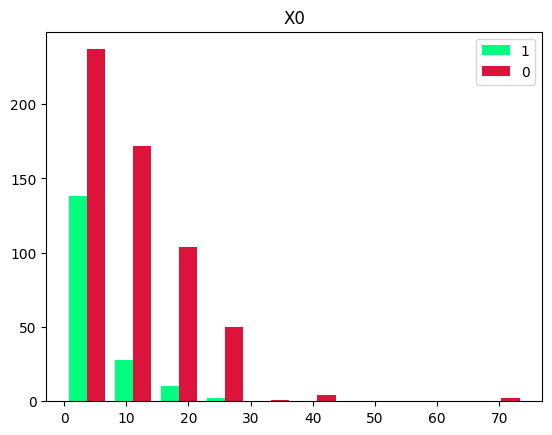

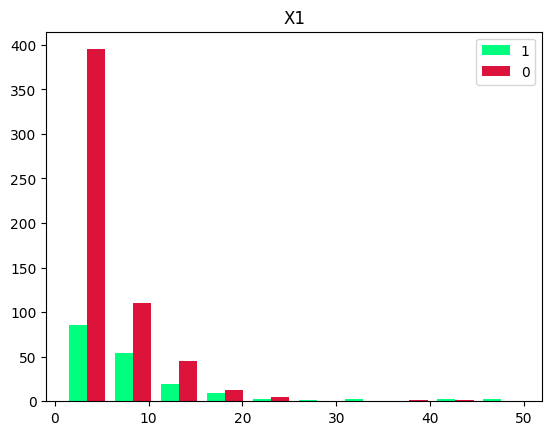

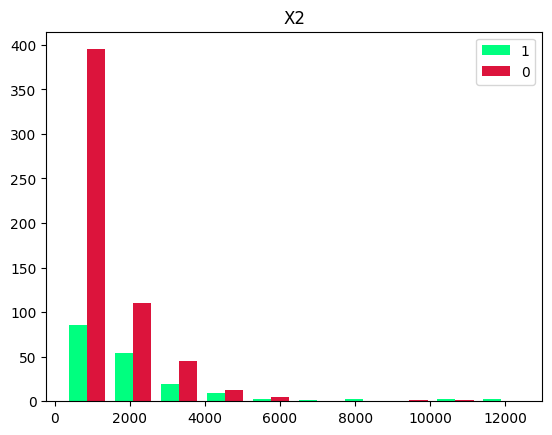

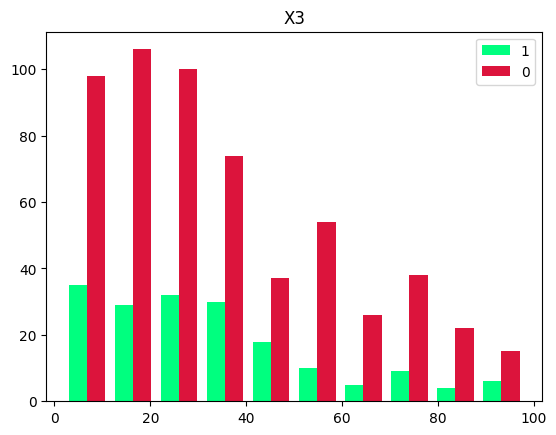

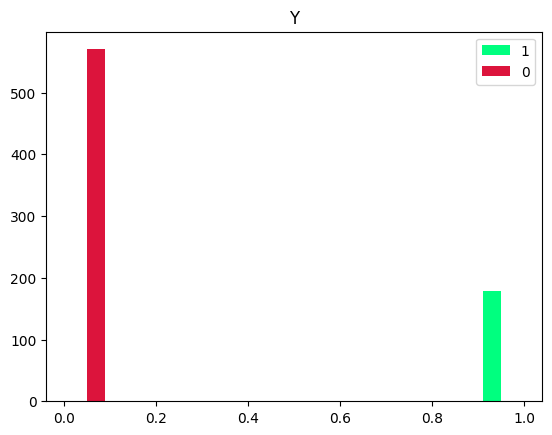

In [6]:
def distClases(data, etiquetas = ['1', '0'], colores=['springgreen', 'crimson']):
    print(f"Distribución de clases en la variable de salida: \n{data['Y'].value_counts()}")
    
    for column in data:  # Visualizamos la distribución de variables por clases
        plt.title(column)
        clases = [data[data['Y'] == eval(i)][column] for i in etiquetas]
        plt.hist(clases, label=etiquetas, color=colores)
        plt.legend(loc='upper right')
        plt.show()


distClases(dataset)

También podemos visualizar los datos y sus clases por pares de atributos:

Correlación numérica entre las variables: 
          X0        X1        X2        X3         Y
X0  1.000000 -0.182745 -0.182745  0.160618 -0.279869
X1 -0.182745  1.000000  1.000000  0.634940  0.218633
X2 -0.182745  1.000000  1.000000  0.634940  0.218633
X3  0.160618  0.634940  0.634940  1.000000 -0.035854
Y  -0.279869  0.218633  0.218633 -0.035854  1.000000


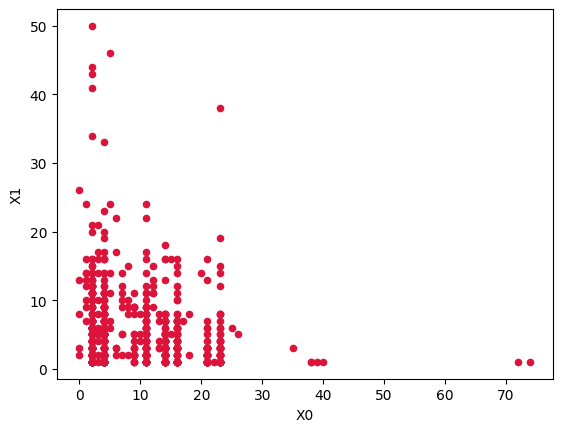

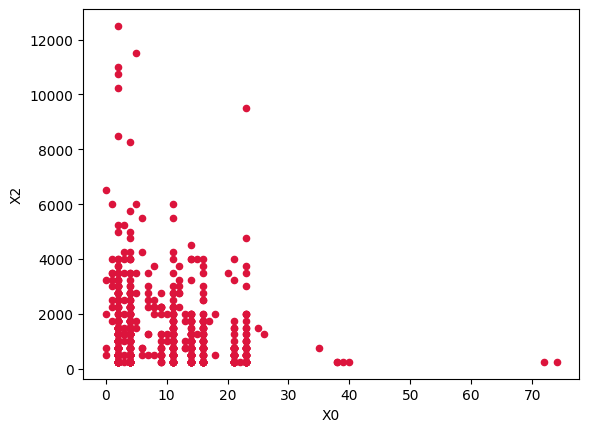

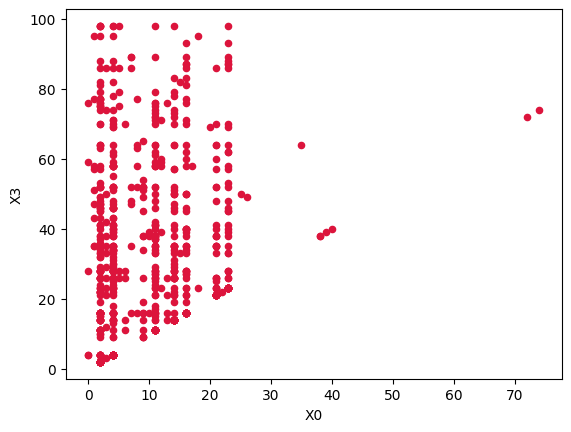

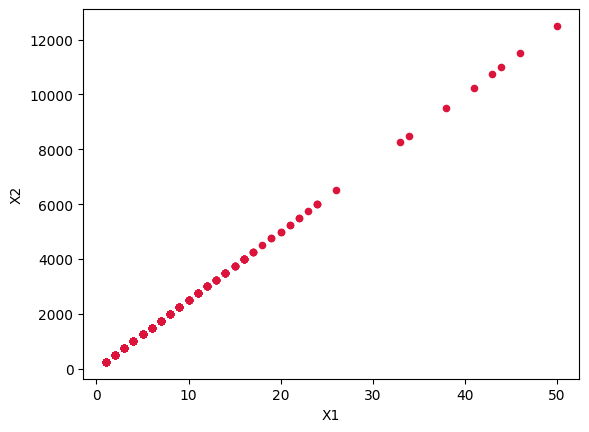

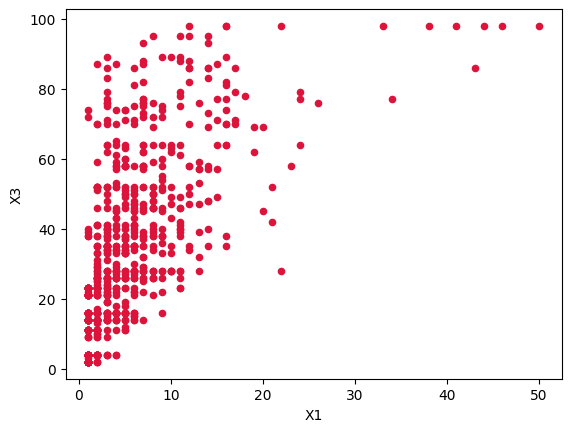

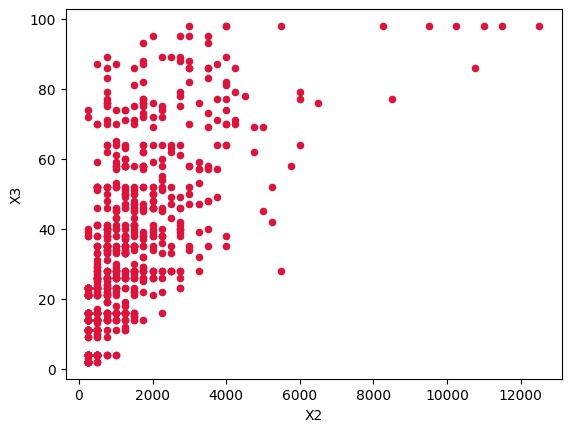

In [7]:
def distPares(data):
    print(f"Correlación numérica entre las variables: \n{data.corr()}") # correlación entre las variables

    column_names = data.columns[:-1]  # Omitimos la variable dependiente
    # Ahora representamos atributos por pares (mostrando también la clase)
    column_names = data.columns[:-1]  # Omitimos la variable dependiente
    for i, columna_i in enumerate(column_names):
        for j, columna_j in enumerate(column_names):
            if i < j:
                fig, ax = plt.subplots()
                data.plot.scatter(columna_i, columna_j, c='crimson', ax=ax)

distPares(dataset)

### División de los datos en entrenamiento (80%) y test (20%)

Para la división de datos entre entrenamiento (80%) y test (20%) usamos `train_test_split`.

In [8]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=SEED_VALUE, stratify=dataset["Y"])
dataset_test

,X0,X1,X2,X3,Y
309,16,3,750,19,0
711,23,6,1500,45,0
343,11,1,250,11,0
462,21,1,250,21,1
646,14,2,500,14,0
...,...,...,...,...,...
315,4,2,500,29,0
473,14,3,750,83,0
661,16,2,500,16,0
362,4,3,750,71,0


**Gestión de valores faltantes**

Como ya vimos en la breve exploración e los datos, nuestro dataset no tiene valores faltantes.
Sin embargo, la sustitución de las variables predictoras por la media se llevaría a cabo de la siguiente manera. `SimpleImputer` convierte nuestros valores a un array NumPy, por lo que sería bueno que se vuelven a convertir a formato dataframe.

In [9]:
def valoresFaltantes(trainData, testData, mis_val=np.nan, fill_val='mean'):
    imp = SimpleImputer(missing_values=mis_val, fill_value=fill_val) # definimos el mapa
    imp = imp.fit(trainData)  # La media la calculamos SÓLO a partir del conjunto de train 

    # Los valores van a ser los mismos que antes, pues no tenemos datos faltantes
    dataset_train_prep = imp.transform(trainData) # aqui modificamos los datos de train
    dataset_test_prep = imp.transform(testData) # aqui modificamos los datos de test (se usa la media de entrenamiento)

    dataset_train = pd.DataFrame(dataset_train_prep, 
                                 columns=trainData.columns, 
                                 index=trainData.index)
    dataset_test = pd.DataFrame(dataset_test_prep, 
                                columns=testData.columns, 
                                index=testData.index)

    return dataset_train, dataset_test

dataset_train, dataset_test = valoresFaltantes(dataset_train, dataset_test)
dataset_test

,X0,X1,X2,X3,Y
309,16.0,3.0,750.0,19.0,0.0
711,23.0,6.0,1500.0,45.0,0.0
343,11.0,1.0,250.0,11.0,0.0
462,21.0,1.0,250.0,21.0,1.0
646,14.0,2.0,500.0,14.0,0.0
...,...,...,...,...,...
315,4.0,2.0,500.0,29.0,0.0
473,14.0,3.0,750.0,83.0,0.0
661,16.0,2.0,500.0,16.0,0.0
362,4.0,3.0,750.0,71.0,0.0


### Separación de variables predictoras y dependientes y estandarización de los datos

Es recomendable hacer siempre la estandarización de los datos. Esto hay que hacerlo **DESPUÉS** de dividir en conjuntos de entrenamiento y test. En los problemas de clasificación, **NO** estandarizaremos la variable dependiente, pero esto sí es necesario en problemas de regresión.

Definimos una función que, dada los datos de entrenamiento y *test*, separa las varibles predictoras y dependientes (especificadas en los parámetros `preds` y `dep`), y estandariza las variables predictoras o las predictoras y las dependientes (el parámetro `escalar = [True, True]` controla el escalado de las variables: el primer elemento indica si se estandarizan las variables predictoras o no (en este último caso da error, ya que es necesario), y el segundo elemento hace lo mismo con las variables dependientes). 

In [10]:
def splitScale(trainData, testData, preds = ['X0', 'X1', 'X2', 'X3'], dep = 'Y', escalar = [True, True]):

    dataset_train_X = trainData.loc[:, preds[0]:preds[-1]].astype(float)
    dataset_train_Y = trainData.loc[:, dep].astype(float)

    dataset_test_X = testData.loc[:, preds[0]:preds[-1]].astype(float)
    dataset_test_Y = testData.loc[:, dep].astype(float)

    if escalar[0]:
        scalerX = StandardScaler() # creamos el scaler
        scalerX.fit(dataset_train_X) # ajustamos a los datos de TRAIN

        dataset_train_X_scaled = scalerX.transform(dataset_train_X)
        dataset_test_X_scaled = scalerX.transform(dataset_test_X)

        print("Valores con los que se ha estandarizado:\n")
        
        statsPreds = pd.DataFrame([scalerX.mean_, scalerX.scale_], 
                                  index = ['Mean', 'std'], 
                                  columns = preds)
        print(f"{statsPreds}\n")

        if escalar[1]:
            
            dataset_train_Y = dataset_train_Y.to_frame()
            dataset_test_Y = dataset_test_Y.to_frame()
            
            scalerY = StandardScaler()
            scalerY.fit(dataset_train_Y) # ajustamos a los datos de TRAIN

            dataset_train_Y_scaled = scalerY.transform(dataset_train_Y)
            dataset_test_Y_scaled = scalerY.transform(dataset_test_Y)

            statsDep = pd.DataFrame([scalerY.mean_, scalerY.scale_], 
                                    index = ['Mean', 'std'], 
                                    columns = [dep])
            print(statsDep)

            return dataset_train_X_scaled, dataset_train_Y_scaled, dataset_test_X_scaled, dataset_test_Y_scaled, [scalerX, scalerY]
        
        return dataset_train_X_scaled, dataset_train_Y, dataset_test_X_scaled, dataset_test_Y, scalerX
    
    else: 
        raise ValueError("Es necesario escalar los predictores")

In [11]:
dataset_train_X_scaled, dataset_train_Y, dataset_test_X_scaled, dataset_test_Y, scalerX = splitScale(dataset_train, dataset_test, preds = ['X0', 'X1', 'X2', 'X3'], dep = 'Y', escalar=[True, False])

Valores con los que se ha estandarizado:

            X0        X1           X2         X3
Mean  9.508361  5.637124  1409.280936  34.879599
std   7.893041  5.893176  1473.294031  24.729957



### Exploración de hiperparámetros

Hemos visualizado y preprocesado los datos. Vamos a empezar a trabajar con nuestro predictor. Importante conocer los hiperparámetros del modelo a usar. Debemos sobreaprender y subaprender. Primero hacemos exploracion de hiperparámetros de grano grueso y luego de grano fino.

`GridSearch` admite una gran variedad de modelos, por lo que definir una función que lo aplique resultará de utilidad. Pasando el modelo a usar el *grid* de hiperparámetros, obtenemos los resultados de los modelos explorados. Además, como lo usaremos con frecuencia, añadimos una columna a los resultados calculando el error medio. 

In [12]:
def crossVal(trainDataX, trainDataY, modelo, hiperparametros, cv = 5, scoring = 'accuracy'):
    modelCV = GridSearchCV(modelo, 
                           param_grid = hiperparametros, # grid de hiperparametros
                           cv = cv, # conjuntos de validacion cruzada (folds)
                           scoring = scoring, # metrica de evaluacion 
                           return_train_score = True)
    
    np.random.seed(SEED_VALUE) 
    modelCV.fit(trainDataX, trainDataY)
    resultados = pd.DataFrame(modelCV.cv_results_)
    
    if scoring == 'accuracy': 
        resultados['mean_test_error'] = 1 - resultados.loc[:, 'mean_test_score']

    return modelCV, resultados

**Exploración de grano grueso**

En esta práctica, exploraremos el parámetro de regularización (`alpha` en `scikit-learn`) y el número de capas (variando entre 1 y 3), así como el número de neuronas en cada capa (que supondremos el mismo en todas las capas). Hacemos primero una exploración de valores en un rango amplio (gg), para subaprender y sobreaprender. De este modo, luego seleccionaremos un rango más limitado de este parámetro y podremos explorar todas las posibilidades en el mismo. 

Concretamente, seleccionamos valores de `alpha` entre 0.001 y 100, en potencias de 10 (0.001, 0.01, 0.1, 1, 10, 100), y de número de capas entre 1 y 3. Cada capa tendrá el mismo número de neuronas, que variará entre 1 y 51, en pasos de 10. Usamos como función de activación la tangente hiperbólica y como algoritmo de optimización el BFGS limitado en memoria. Fijamos un máximo de 2000 iteraciones.

In [ ]:
valoresC_gg = [10**i for i in range(-4, 8, 3)]
grados_gg = [2, 3, 4, 5]
gamma_gg = [10**i for i in range(-4, 8, 3)]

hyperparameters_gg = [{'kernel': ['linear'], 'C': valoresC_gg}, 
                       {'kernel': ['poly'], 'C': valoresC_gg, 'degree': grados_gg, 'gamma': [1]}, 
                       {'kernel': ['rbf'], 'C': valoresC_gg, 'gamma': gamma_gg}]

svm_gg = SVC(random_state=SEED_VALUE)

modeloCV_gg, cv_results_gg = crossVal(dataset_train_X_scaled, np.ravel(dataset_train_Y.astype(int)),
                                       svm_gg, hyperparameters_gg)
modeloCV_gg

**Gráfica de entrenamiento (primera aproximación)**

Aqui deberiamos tener una grafica más o menos convexa para ver que ahi esta el minimo. Hacemos una función que grafique el error frente al número de neuronas por capa; mostraremos una gráfica para cada valor de `alpha`, dibujando tres *plots* en cada una, uno para cada número de capas.

In [54]:
def errorVal(resultados, fig, kernel_type='linear', label='SVM', color='crimson', classification=True):
    # Calcular error
    if classification:
        resultados['mean_test_error'] = 1 - resultados['mean_test_score']
    else:
        resultados['mean_test_error'] = resultados['mean_test_score']
    
    results = pd.DataFrame({'C': resultados['param_C'], 
                           'mean_test_error': resultados['mean_test_error'], 
                           'std_test_score': resultados['std_test_score'], 
                           'rank_test_score': resultados['rank_test_score']})
    
    if kernel_type == 'poly':
        results['grado'] = resultados['param_degree']
        param_values = sorted(results['grado'].unique())
        param_name = 'grado'
    elif kernel_type == 'rbf':
        results['gamma'] = resultados['param_gamma']
        param_values = sorted(results['gamma'].unique())
        param_name = 'gamma'
    else: 
        param_values = [None]
        param_name = None

    # Definir colores
    colores = ['crimson', 'royalblue', 'orange', 'navy', 'indigo']
    
    ax = fig.axes[0]
    
    # Iterar sobre param_values
    for idx, param_val in enumerate(param_values):
        if param_name:
            datos = results[results[param_name] == param_val]
            label_text = f"{param_name}={param_val}"
        else:
            datos = results
            label_text = label
            
        ax.errorbar(datos['C'], datos['mean_test_error'], 
                   yerr=datos['std_test_score'], 
                   label=label_text, 
                   color=colores[idx % len(colores)], 
                   capsize=3)
    
    ax.set_xscale('log')
    ax.set_xlabel("C")
    ax.set_ylabel("Error de validación cruzada")
    ax.set_title(f'Kernel {kernel_type}')
    ax.legend()
    ax.grid(True, alpha=0.5)
    
    return ax

In [67]:
def errorVal2(resultados, fig, kernel_type='linear', label='SVM', color='crimson', classification=True):
    # Calcular error
    if classification:
        resultados['mean_test_error'] = 1 - resultados['mean_test_score']
    else:
        resultados['mean_test_error'] = resultados['mean_test_score']
    
    results = pd.DataFrame({'C': resultados['param_C'], 
                           'mean_test_error': resultados['mean_test_error'], 
                           'std_test_score': resultados['std_test_score'], 
                           'rank_test_score': resultados['rank_test_score']})
    
    ax = fig.axes[0]
    colores = ['crimson', 'royalblue', 'orange', 'navy', 'indigo']
    
    if kernel_type == 'poly':
        results['grado'] = resultados['param_degree']
        # Para poly, iteramos sobre valores únicos de C
        C_values = sorted(results['C'].unique())
        
        for idx, C_val in enumerate(C_values):
            datos = results[results['C'] == C_val]
            ax.errorbar(datos['grado'], datos['mean_test_error'], 
                       yerr=datos['std_test_score'], 
                       label=f"C={C_val}", 
                       color=colores[idx % len(colores)], 
                       capsize=3)
        
        ax.set_xlabel("Grado del polinomio")
        
    elif kernel_type == 'rbf':
        results['gamma'] = resultados['param_gamma']
        gamma_values = sorted(results['gamma'].unique())
        
        for idx, gamma_val in enumerate(gamma_values):
            datos = results[results['gamma'] == gamma_val]
            ax.errorbar(datos['C'], datos['mean_test_error'], 
                       yerr=datos['std_test_score'], 
                       label=f"gamma={gamma_val}", 
                       color=colores[idx % len(colores)], 
                       capsize=3)
        
        ax.set_xlabel("C")
        ax.set_xscale('log')
        
    else:  # linear
        ax.errorbar(results['C'], results['mean_test_error'], 
                   yerr=results['std_test_score'], 
                   label=label, 
                   color=colores[0], 
                   capsize=3)
        ax.set_xlabel("C")
        ax.set_xscale('log')
    
    ax.set_ylabel("Error de validación cruzada")
    ax.set_title(f'Kernel {kernel_type}')
    ax.legend()
    ax.grid(True, alpha=0.5)
    
    return ax

Hacemos la representación de los resultados de la exploracion de grano grueso.

/var/folders/cx/qn6km0h17314hbjnc7y0wdy40000gn/T/ipykernel_74859/865267603.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultados['mean_test_error'] = 1 - resultados['mean_test_score']
/var/folders/cx/qn6km0h17314hbjnc7y0wdy40000gn/T/ipykernel_74859/865267603.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultados['mean_test_error'] = 1 - resultados['mean_test_score']


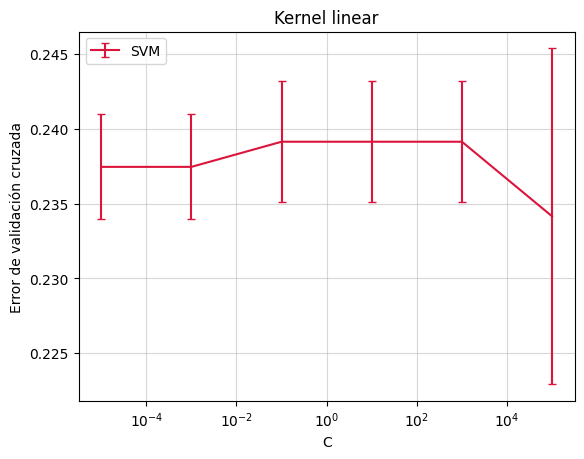

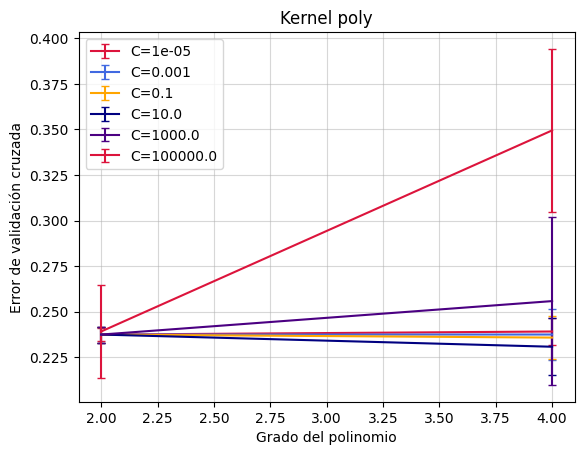

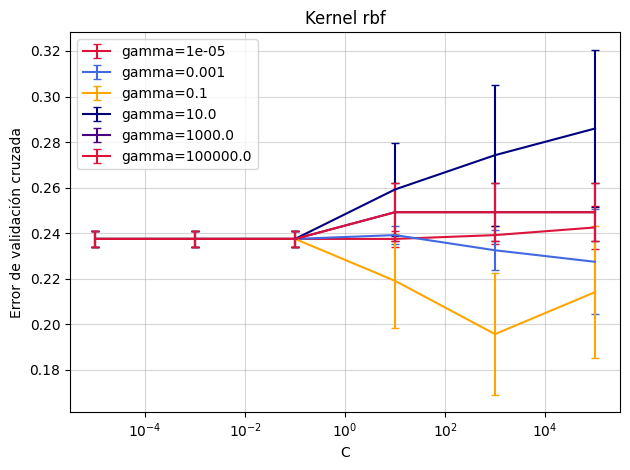

In [68]:
fig_gg, axes_gg = plt.subplots(1,1)
fig_gg2, axes_gg2 = plt.subplots(1,1)
fig_gg3, axes_gg3 = plt.subplots(1,1)

errorVal2(cv_results_gg[cv_results_gg['param_kernel'] == 'linear'], fig_gg, kernel_type='linear')
errorVal2(cv_results_gg[cv_results_gg['param_kernel'] == 'poly'], fig_gg2, kernel_type='poly')
errorVal2(cv_results_gg[cv_results_gg['param_kernel'] == 'rbf'], fig_gg3, kernel_type='rbf')

plt.tight_layout()
plt.show()

Buscamos una gráfica más o menos convexa, para hacer una búsqueda de grano fino en el entorno del mínimo. Además, nos interesa que el mínimo tenga el menor error posible. Nos fijamos entonces en las gráficas con el parámetro de regularizacion igual a 1, con una o dos capas ocultas. Estas dos son, las curvas convexas que presentan un error más bajo, por lo que los hiperparámetros óptimos se deberían encontrar con estos valores.  

**Exploración de grano fino**

Repetimos la exploración, esta vez barriendo todos los valores del intervalo. Así encontraremos el modelo con el menor error de validación cruzada para este problema. Concretamente, usaremos una y dos capas ocultas, con entre 1 y 40 neuronas cada capa (de uno en uno). Para el parámetro de regularizacion, cogeremos 1 y su entorno, es decir, 0.5 y 5; esto nos da más precisión a la hora de buscar el valor óptimo. 

In [ ]:
valoresC_gf = [10**i for i in range(-4, 8, 2)]
grados_gf = [2, 4]
gamma_gf = [10**i for i in range(-4, 8, 2)]

hyperparameters_gf = [{'kernel': ['linear'], 'C': valoresC_gf}, 
                       {'kernel': ['poly'], 'C': valoresC_gf, 'degree': grados_gf, 'gamma': [1]}, 
                       {'kernel': ['rbf'], 'C': valoresC_gf, 'gamma': gamma_gf}]

svm_gf= SVC(random_state=SEED_VALUE)

modeloCV_gf, cv_results_gf = crossVal(dataset_train_X_scaled, np.ravel(dataset_train_Y.astype(int)),
                                       svm_gf, hyperparameters_gf)
modeloCV_gf

Veamos el mejor modelo para cada kernel y sus estadísticas:

In [ ]:
cv_results_linear = cv_results_gf[cv_results_gf['param_kernel'] == 'linear']
cv_results_poly = cv_results_gf[cv_results_gf['param_kernel'] == 'poly']
cv_results_rbf = cv_results_gf[cv_results_gf['param_kernel'] == 'rbf']

Para el kernel lineal:

In [ ]:
cv_results_linear[cv_results_linear['rank_test_score'] == min(list(cv_results_linear['rank_test_score']))]

Para el kernel polinómico:

In [ ]:
cv_results_poly[cv_results_poly['rank_test_score'] == min(list(cv_results_poly['rank_test_score']))]

Para el kernel radial:

In [ ]:
cv_results_rbf[cv_results_rbf['rank_test_score'] == min(list(cv_results_rbf['rank_test_score']))]

**Gráfica de entrenamiento**

A continuación mostramos la gráfica del error de entrenamiento con validación cruzada frente al número de neuronas por capa, para cada número de capas ocultas y para cada valor de `alpha`.

/var/folders/cx/qn6km0h17314hbjnc7y0wdy40000gn/T/ipykernel_74859/1612800870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultados['mean_test_error'] = 1 - resultados['mean_test_score']
/var/folders/cx/qn6km0h17314hbjnc7y0wdy40000gn/T/ipykernel_74859/1612800870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultados['mean_test_error'] = 1 - resultados['mean_test_score']


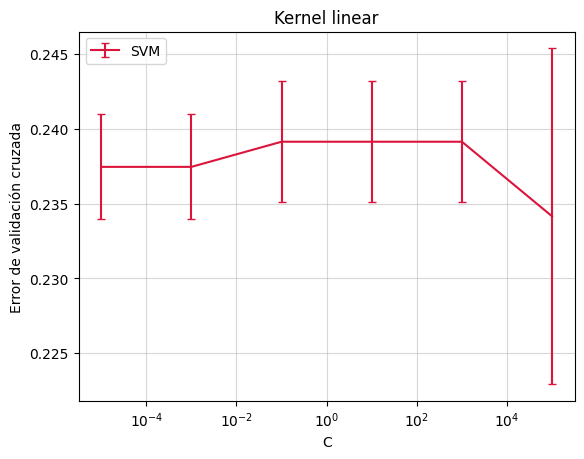

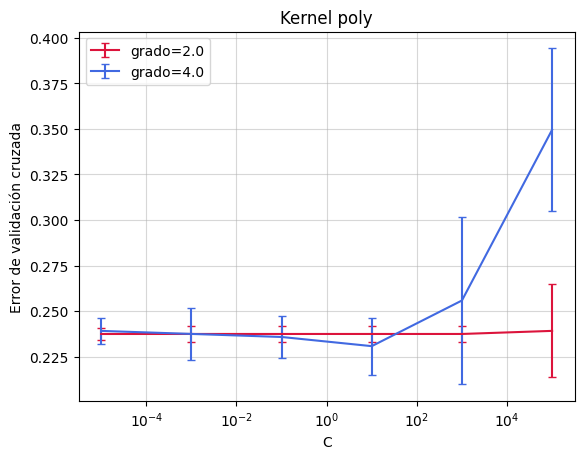

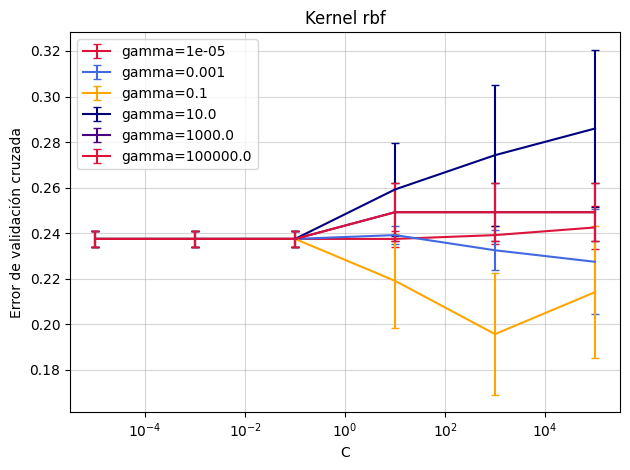

In [ ]:
fig_gf, axes_gf = plt.subplots(1,1)
fig_gf2, axes_gf2 = plt.subplots(1,1)
fig_gf3, axes_gf3 = plt.subplots(1,1)

errorVal(cv_results_linear, fig_gf, kernel_type='linear')
errorVal(cv_results_poly, fig_gf2, kernel_type='poly')
errorVal(cv_results_rbf, fig_gf3, kernel_type='rbf')

plt.tight_layout()
plt.show()

Aquí podemos ver visualmente los resultados anteriores: el mejor modelo lo tenemos con una única capa oculta de 3 neuronas, y un valor de `alpha` de 0.5.

### Verificación de hiperparámetros en *test*

Esto no se haría **JAMÁS** en una situación real. Pero como este es un ejemplo para aprender, vamos a ver cómo de lejos nos hemos quedado de los hiperparámetros "ideales". Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo (80% de los datos) y nuestro conjunto de validación va a ser el conjunto de test (20% de los datos).

In [ ]:
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold) # fijamos una particion de datos (forzamos al metodo a que particione como queremos)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y])

svm_test = SVC(random_state=SEED_VALUE)

modeloCV_test, cv_results_test = crossVal(dataset_all_X_scaled, np.ravel(dataset_all_Y.astype(int)), 
                                          svm_test, hyperparameters_gf, cv = ps)
modeloCV_test

/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=MLPClassifier(activation='tanh', max_iter=2000,
                                     random_state=1, solver='lbfgs'),
             param_grid={'alpha': [0.5, 1, 5],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                (6,), (7,), (8,), (9,), (10,),
                                                (11,), (12,), (13,), (14,),
                                                (15,), (16,), (17,), (18,),
                                                (19,), (20,), (21,), (22,),
                                                (23,), (24,), (25,), (26,),
                                                (27,), (28,), (29,), (30,), ...]},
             return_train_score=True, scoring='accuracy')

El error de *test* para el valor del hiperparámetro seleccionado por la validación cruzada será:

In [ ]:
best_linear_test = cv_results_test[(cv_results_test['param_kernel'] == 'linear') & 
                                   (cv_results_test['param_C'] == 10000)]

best_poly_test = cv_results_test[(cv_results_test['param_kernel'] == 'poly') & 
                                 (cv_results_test['param_C'] == 10000) & 
                                 (cv_results_test['param_degree'] == 2) & 
                                 (cv_results_test['param_gamma'] == 1)]

best_rbf_test = cv_results_test[(cv_results_test['param_kernel'] == 'rbf') & 
                                 (cv_results_test['param_C'] == 10000) & 
                                 (cv_results_test['param_gamma'] == 0.01)]

**Kernel lineal**

In [ ]:
best_linear_test.loc[:, ['param_C', 'param_kernel', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

**Kernel polinómico**

In [ ]:
best_poly_test.loc[:, ['param_C', 'param_kernel', 'param_degree', 'param_gamma', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

**Kernel radial**

In [ ]:
best_rbf_test.loc[:, ['param_C', 'param_kernel', 'param_gamma', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

**Error de validación vs test**

Ahora mostramos la gráfica del error de *test* frente al valor del hiperparámetro junto con la del error de entrenamiento, lo que permitirá comparar si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de *test*.

In [ ]:
fig_test, axes_test = plt.subplots(1,1)
fig_test2, axes_test2 = plt.subplots(1,1)
fig_test3, axes_test3 = plt.subplots(1,1)

cv_results_linear


errorVal(cv_results_linear, fig_test, kernel_type='linear')
errorVal(cv_results_test[cv_results_test['param_kernel'] == 'linear'], fig_test, kernel_type='linear')

errorVal(cv_results_poly[cv_results_poly['param_C'] == 1.0], fig_test2, kernel_type='poly')
errorVal(cv_results_test[(cv_results_test['param_kernel'] == 'poly') & 
                         (cv_results_test['param_C'] == 1.0)], fig_test2, kernel_type='poly')

errorVal(cv_results_rbf[cv_results_rbf['param_gamma'] == 1.0], fig_test3, kernel_type='rbf')
errorVal(cv_results_test[(cv_results_test['param_kernel'] == 'rbf') & 
                         (cv_results_test['param_gamma'] == 1.0)], fig_test3, kernel_type='rbf')

plt.tight_layout()
plt.show()

Vemos que el error de *test* oscila en gran medida entorno al error de validación encontrado. El error de *test* para el valor del hiperparámetro seleccionado por la validación cruzada será: